In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from itertools import product
from simulation_utils import *
from test_utils import *

from os import chdir

from tqdm.auto import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def simulate(n_reps = 3, n_sample=500, n_quant = 128,
                kernel_X = 'constant',sig_X=5,
                kernel_Y = 'constant',sig_Y=5,
                sig_Z=5,beta1=1,
                box_params = {'max_depth':1,'n_estimators':200,'eta':0.1},
                L2_pen=1,n_splits=5,
                dependency = 0):

    (T_plug,T_corrected,T_double,sig_list,sigd_list,p_cox) = ([] for _ in range(6))

    data_sampler = cox_sampler(sig_X,sig_Y,sig_Z,dependency,beta1,kernel_X,kernel_Y,n_quant)
    data_sampler.scale_and_set_baseline()

    for _ in tqdm(range(n_reps), leave=False):
        X,Y,Z,tau = data_sampler.sample_all(n_sample)

        g_p, g_c, sig, best_params = compute_gamma(tau,Z,X,box_params,n_quant,L2_pen=L2_pen,cross_validate=True)
        g_d, sig_d = compute_gamma_double(tau,Z,X,best_params, n_quant, n_splits=n_splits,L2_pen=L2_pen)


        T_plug.append(np.linalg.norm(g_p,ord=np.inf))
        T_corrected.append(np.linalg.norm(g_c,ord=np.inf))
        T_double.append(np.linalg.norm(g_d,ord=np.inf))
        sig_list.append(sig[-1])
        sigd_list.append(sig_d[-1])
        p_cox.append(cox_test(X,Z,tau))
    
    df = pd.DataFrame({
        "T_plug":T_plug,
        "T_corrected":T_corrected,
        "T_double":T_double,
        "sigma":sig_list,
        "sigma_double":sigd_list,
        "p_cox":p_cox,
        "n_sample": n_sample*np.ones(n_reps),
        "beta1": beta1*np.ones(n_reps),
        "kernel_X": [kernel_X]*n_reps,
        "kernel_Y": [kernel_Y]*n_reps,
        "alt_param": [dependency]*n_reps
    })
    return df

In [4]:
sim_data = simulate(
    n_reps = 2, n_sample=200, n_quant=128,
    sig_X=5, kernel_X='constant',
    sig_Y=5, kernel_Y='constant',
    sig_Z=5,
    beta1=1,
    box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
    L2_pen=0.0001,n_splits=5,
    dependency=0
)

In [6]:
simulation_data = []

## Simulation settings
kernel_list = ['constant','gaussian','sine']
beta_list = [-1,1]
sample_sizes = [100,500,1000,2000]
dependency_param = [0,10,20,30]
n_sim = len(kernel_list) * len(beta_list) * len(sample_sizes) * len(dependency_param)
param_grid = product(kernel_list,beta_list,sample_sizes,dependency_param)

for kernel,beta_1,sample_size,dependency in tqdm(param_grid, position = 0, leave=True, total=n_sim):
    sim_data = simulate(
        n_reps = 300, n_sample=sample_size,
        sig_X=5, kernel_X=kernel,
        sig_Y=5, kernel_Y=kernel,
        sig_Z=5,
        beta1=beta_1,
        box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
        L2_pen=0.001,n_splits=5,
        dependency=dependency
    )
    simulation_data.append(sim_data)
full_data = pd.concat(simulation_data)

 58%|█████▊    | 56/96 [11:23:51<8:08:28, 732.70s/it]


KeyboardInterrupt: 

In [31]:
param_grid = product(kernel_list,beta_list,sample_sizes,dependency_param)

for i,(kernel,beta_1,sample_size,dependency) in tqdm(enumerate(param_grid),total=n_sim):
    if i==56:
        sim_data = simulate(
            n_reps = 300, n_sample=sample_size,
            sig_X=5, kernel_X=kernel,
            sig_Y=5, kernel_Y=kernel,
            sig_Z=5,
            beta1=beta_1,
            box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
            L2_pen=0.001,n_splits=5,
            dependency=dependency
        )
        simulation_data.append(sim_data)

100%|██████████| 96/96 [11:35<00:00,  7.24s/it]


In [24]:
simulation_data[55].head(1)

,T_plug,T_corrected,T_double,sigma,sigma_double,p_cox,n_sample,beta1,kernel_X,kernel_Y,alt_param
0,0.125666,0.249474,0.019552,0.237155,0.040645,0.770336,500.0,1.0,gaussian,gaussian,30


In [32]:
full_data = pd.concat(simulation_data)

In [33]:
path = '/Users/bwq666/Documents/BoxHed/'
if 0:
    with open(path+'/sim_data/' + 'DMLvsCox.pkl', 'wb') as f:
        pickle.dump(full_data, f)


In [96]:
p_value = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]/np.sqrt(x[1])) # x = (statistic, variance, samplesize)
#data['p_plug'] = sim_data[['T_plug','sigma','n_sample']].apply(p_value,axis=1)
data['p_orth'] = data[['T_corrected','sigma','n_sample']].apply(p_value,axis=1)
data['p_double'] = data[['T_double','sigma_double','n_sample']].apply(p_value,axis=1)

In [97]:
df_pvals = pd.melt(
    data, id_vars=['n_sample','alt_param','beta1','kernel_X'],value_vars=['p_double','p_cox']
)
if len(df_pvals['beta1'].unique()) > 1:
    parameter_name = r'$(\gamma,\beta,k)$'
    df_pvals[parameter_name] = list(zip(df_pvals.alt_param,df_pvals.beta1,df_pvals.kernel_X))
else:
    parameter_name = r'dependency'
    df_pvals[parameter_name] = df_pvals.alt_param

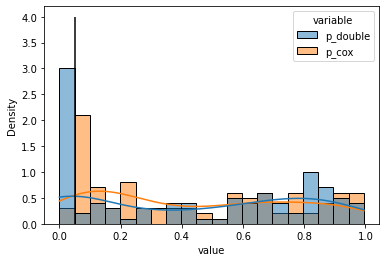

In [98]:
sns.histplot(df_pvals,x='value',hue='variable',stat='density', bins=20,kde=True)
plt.vlines(0.05,0,4,'k')
plt.show()

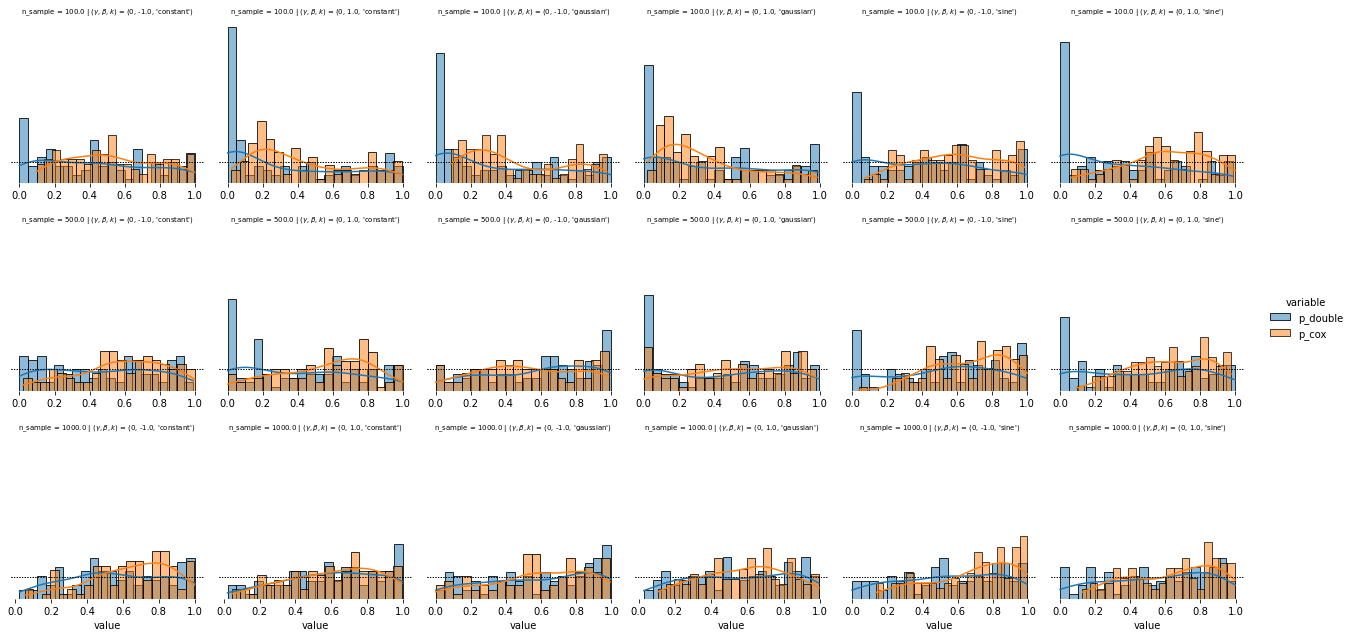

In [57]:

g = sns.FacetGrid(df_pvals, row='n_sample', col=parameter_name, hue='variable',sharex=False)
g.map(sns.histplot,'value',kde=True,stat='density',bins=20)
g.add_legend()
g.refline(y=1, linewidth=1, linestyle=':',color='k', clip_on=False)

#g.figure.subplots_adjust(hspace=-.25)
g.set_titles(size='x-small')
g.set(yticks=[], ylabel="")

g.despine(bottom=True, left=True)
#plt.savefig(path+'/p_vals.pdf')
plt.show()

In [102]:
sampler = cox_sampler()
X,Y,Z,tau = sampler.sample_all()


# Old code

In [ ]:
pvals_Y = []
pvals_W = []
pvals_Z = []
betas_Y = []
betas_W = []
betas_Z = []

for _ in tqdm(range(1000)):
    X = sample_X_jump(500,10,128)[0]
    Y = sample_y(X,noise=sig_Y,drift=xi_Y,a=a_Y)

    tau = sample_tau(
        X,Y,link = lambda x: np.exp(x), #lambda x: np.exp(np.minimum(x, 1) - 1)*(x<1) + x*(x>=1),
        baseline = lambda t: 4*(t**2),
        return_hazard=False,beta_1=-2
    )
    Z = sample_y(X,noise=sig_Z,drift=xi_Z,a=a_Z)
    W = 0.5*Y + 0.5*Z

    beta_Y,pval_Y = cox_test(X,Y,tau)
    beta_W,pval_W = cox_test(X,W,tau)
    beta_Z,pval_Z = cox_test(X,Z,tau)

    pvals_Y.append(pval_Y)
    pvals_W.append(pval_W)
    pvals_Z.append(pval_Z)

    betas_Y.append(beta_Y)
    betas_W.append(beta_W)
    betas_Z.append(beta_Z)

estimates = pd.DataFrame({
    'beta_Y':betas_Y,
    'beta_W':betas_W,
    'beta_Z':betas_Z,
    'p_Y':pvals_Y,
    'p_W':pvals_W,
    'p_Z':pvals_Z
})

In [ ]:
path = '/Users/bwq666/Documents/BoxHed/'
if 1:
    with open(path+'/sim_data/' + 'marginal_cox_test1.pkl', 'wb') as f:
        pickle.dump(estimates, f)

if 1:
    with open(path+'/sim_data/' + 'marginal_cox_test1.pkl','rb') as f:
        estimates = pickle.load(f)

In [ ]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

path = '/Users/bwq666/Documents/BoxHed/Plots'; chdir(path)

In [ ]:
sns.set()
fig, (a1,a2) = plt.subplots(2,1,figsize=(12,6))

a1.hist(estimates["beta_Y"], label=r"$\hat{\beta}_Y$",density=True, alpha=0.7,bins=20)
a1.hist(estimates["beta_W"], label=r"$\hat{\beta}_W$",density=True, alpha=0.7,bins=20)
a1.hist(estimates["beta_Z"], label=r"$\hat{\beta}_Z$",density=True, alpha=0.7,bins=20)
a1.axvline(np.mean(estimates["beta_Y"]), color="tab:orange")
a1.axvline(np.mean(estimates["beta_W"]), color="tab:blue")
a1.axvline(np.mean(estimates["beta_Z"]), color="tab:green")
a1.legend()

a2.hist(estimates["p_Y"],label="$p_Y$",density=True, alpha=0.7,bins=20); plt.legend()
a2.hist(estimates["p_W"],label="$p_W$",density=True, alpha=0.7,bins=20); plt.legend()
a2.hist(estimates["p_Z"],label="$p_Z$",density=True, alpha=0.7,bins=20); plt.legend()
a2.axvline(0.05,color="k", linestyle="dashed")
a2.plot(np.linspace(0,1,10),np.ones(10),"k:")
a2.legend()

#plt.savefig('hazardratios_and_pvalues.pdf')
plt.show()